In [1]:
using DelimitedFiles
using PyCall
using PyPlot
using Random
using Setfield
using Statistics
using ProgressMeter
using JLD2
using HDF5
using Printf
using FileIO
using DataStructures
using DrWatson
using Measurements

using Revise

using CMBLensing
using PtsrcLens
using CUDA

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1664


# Load pre-processed

In [2]:
# @unpack ϕs, κs, gs, Ms = load_hdf5_cutouts();
# @save "data/sehgal_maps_h5/cutouts.jld2" ϕs κs gs Ms

In [3]:
@load "data/sehgal_maps_h5/cutouts.jld2" ϕs κs gs Ms

4-element Vector{Symbol}:
 :ϕs
 :κs
 :gs
 :Ms

# Check power

In [4]:
fg_noise = @time get_foreground_noise(;Ms, gs);

 19.552198 seconds (23.77 M allocations: 6.402 GiB, 5.24% gc time, 56.90% compilation time: 0% of which was recompilation)


In [5]:
fg_noise[:radio]

OrderedDict{Tuple{Symbol, Int64, Real}, Measurement{Float64}} with 16 entries:
  (:deep, 90, 2)    => 0.074±0.039
  (:deep, 90, 5)    => 0.13±0.022
  (:deep, 90, 10)   => 0.186±0.016
  (:deep, 90, Inf)  => 1.3494±0.0035
  (:deep, 148, 2)   => 0.035±0.034
  (:deep, 148, 5)   => 0.057±0.02
  (:deep, 148, 10)  => 0.08±0.015
  (:deep, 148, Inf) => 0.6734±0.0022
  (:wide, 90, 2)    => 0.075±0.12
  (:wide, 90, 5)    => 0.132±0.071
  (:wide, 90, 10)   => 0.187±0.05
  (:wide, 90, Inf)  => 1.3494±0.0072
  (:wide, 148, 2)   => 0.036±0.052
  (:wide, 148, 5)   => 0.059±0.031
  (:wide, 148, 10)  => 0.082±0.023
  (:wide, 148, Inf) => 0.6734±0.0029

# Plot

In [6]:
Cℓ = camb();

In [7]:
fg_noise[:radio][:deep, 148, 2]

0.035 ± 0.034

In [8]:
gs[:radio] |> keys

KeySet for a Dict{Int64, Vector{LambertQUMap{Array{Float32, 3}}}} with 2 entries. Keys:
  90
  148

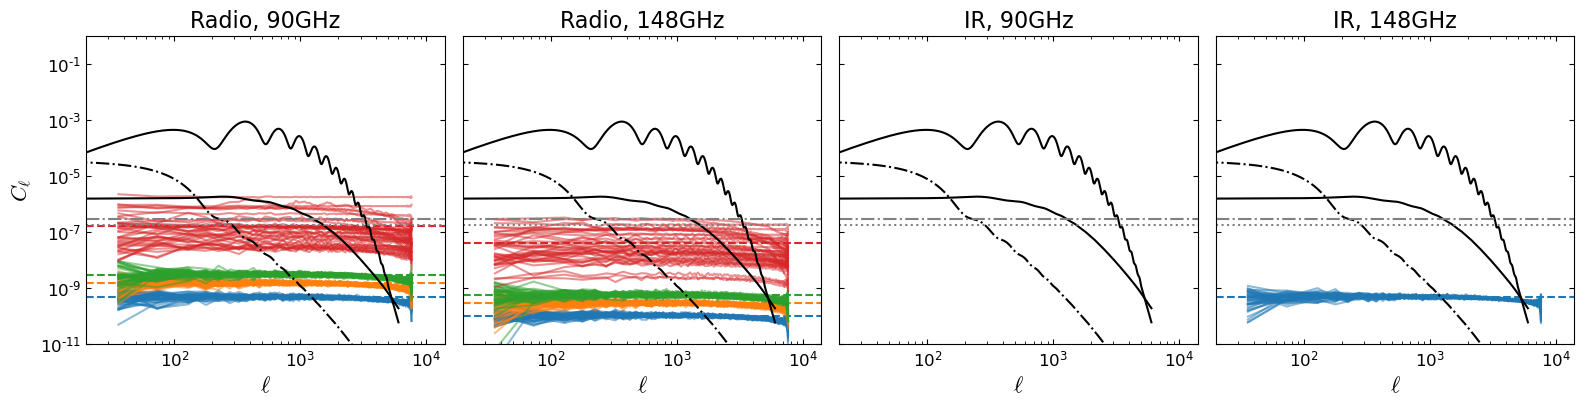

In [9]:
figure(figsize=(3*6.4,4))
survey = :deep

for (j,freq) in enumerate([90,148])
    
    for (i,fgtype) in enumerate([:radio,:ir])
        
        ax = subplot(1,4,2*(i-1)+j)
        
        if (freq,fgtype) != (90,:ir)

            for (c,fluxcut) in enumerate(fgtype == :radio ? Any[2,5,10,Inf] : Any[Inf])
                let (Ms, gs, μKarcmin) = (Ms[fgtype][survey,freq,fluxcut], gs[fgtype][freq], fg_noise[fgtype][survey,freq,fluxcut])
                    for k in sims
                        loglog(get_Cℓ(Ms[k] * gs[k], which=:QQ), c="C$(c-1)", alpha=0.5)
                    end
                    axhline(noiseCℓs(μKarcminT=Measurements.value(μKarcmin)/√2, ℓknee=0).EE[2], c="C$(c-1)", ls="--", label="average power spectrum")
                end
            end
            
        end

        loglog(Cℓ.unlensed_scalar.EE, "k")
        loglog(Cℓ.lensed_scalar.BB, "k")
        loglog(Cℓ.tensor.BB, "k-.")
        axhline(2.8e-7, c="gray", ls="-.", label="Crites et al. 2015")
        axhline(noiseCℓs(μKarcminT=1, αknee=0).TT[2], c="gray", ls=":", label="1 μKarcmin noise")

        title("$(["Radio","IR"][i]), $([90,148][j])GHz")
        
        ylim(1e-11, 1e0)
        xlim(20,1.4e4)
        if i==j==1
            ylabel(L"C_\ell")
        else
            ax.set_yticklabels([])
        end
        xlabel(L"\ell")
        
    end

end
subplots_adjust(wspace=0.05)
savefig("figures/powerspectra.pdf", bbox_inches="tight")

# Grid

In [116]:
source = :radio
survey = :deep
fluxcut = 10
polfrac_scale = 1

1

In [54]:
get_σ(k, MAPs=MAPs) = 1 ./ std(reduce(hcat, [MAP[k].gAϕ[end] for MAP in MAPs]), dims=2)[:]
get_bias((k1, k2), MAPs=MAPs) = get_σ(("FG_FREE", false)) .* mean([MAP[k1].gAϕ[end] - MAP[k2].gAϕ[end] for MAP in MAPs])
function get_tot_bias((k1, k2), MAPs=MAPs)
    Cℓ_bias = get_bias((k1, k2), MAPs)
    σℓ = get_σ(("FG_FREE", false), MAPs)
    sum(@. Cℓ_bias / σℓ^2) / sum(@. 1 / σℓ^2) / sqrt(1 / sum(@. 1 / σℓ^2))
end

get_tot_bias (generic function with 2 methods)

In [131]:
freq = 90
biases = map([3000, 4000, 5000]) do ℓmax_data
    MAPs = @showprogress map(1:13) do sim
        config = (;source, survey, freq, ℓmax_data, fluxcut, polfrac_scale, sim)
        MAPs = load(MAP_filename("jld2"; config...), "MAPs")
    end;
    get_tot_bias((("CUTOUT_CORRELATED",true),("GAUSSIAN",true)), MAPs)
end;

Progress:  64%|██████████████████████████▍              |  ETA: 0:00:02

LoadError: ArgumentError: No file exists at given path: /global/u1/m/marius/work/ptsrclens/data/MAPs/fluxcut=10_freq=90_polfrac_scale=1_sim=14_source=radio_survey=deep_ℓmax_data=3000.jld2

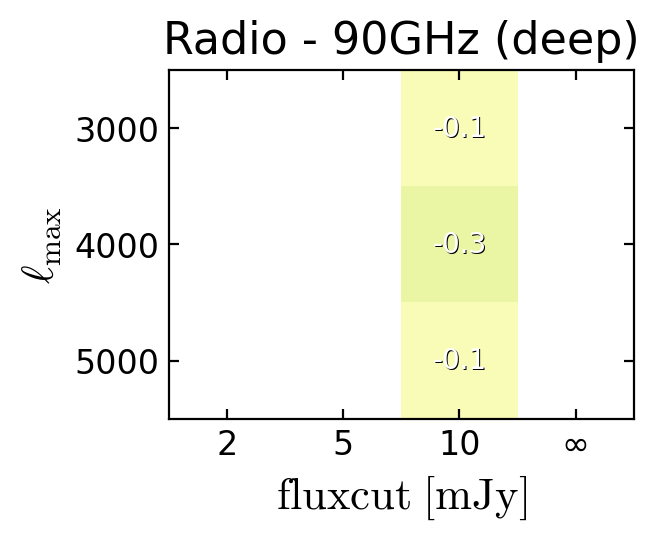

PyObject Text(0.5, 1.0, 'Radio - 90GHz (deep)')

In [129]:
figure(figsize=(3,4), dpi=200)
data = fill(NaN, 3, 4)
data[:,3] .= biases
gca().imshow(data, vmin=-3, vmax=3, cmap="RdYlGn_r")
for I in CartesianIndices(data)
    if !isnan(data[I])
        text((reverse(I.I) .- 0.99)..., @sprintf("%.1f",data[I]), ha="center", va="center", c="black")
        text((reverse(I.I) .- 1)..., @sprintf("%.1f",data[I]), ha="center", va="center", c="white")    
    end
end
xticks(0:3)
gca().set_xticklabels(["2","5","10","∞"])

yticks(0:2)
gca().set_yticklabels(3000:1000:5000);
ylabel(L"\ell_{\rm max}")
xlabel(L"{\rm fluxcut} \; [{\rm mJy}]")
title("Radio - $(freq)GHz ($survey)")

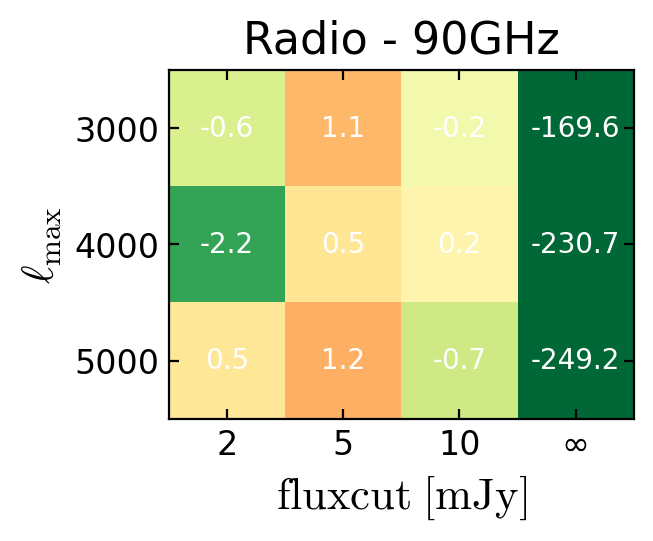

PyObject Text(0.5, 1.0, 'Radio - 90GHz')

In [26]:
figure(figsize=(3,4), dpi=200)
data = (first.(reduce(hcat, biases)))
gca().imshow(data, vmin=-3, vmax=3, cmap="RdYlGn_r")
for I in CartesianIndices(data)
    text((reverse(I.I) .- 1)..., @sprintf("%.1f",data[I]), ha="center", va="center", c="white")
end
gca().set_xticklabels([nothing,"2","5","10","∞"])
gca().set_yticklabels(2000:1000:5000);
ylabel(L"\ell_{\rm max}")
xlabel(L"{\rm fluxcut} \; [{\rm mJy}]")
title("Radio - 90GHz")

# Analyze MAPs

In [10]:
# ℓedges = round.(Int, 10 .^ range(log10(25), log10(6000), length=10));
# ℓedges = [25, 50, 75, 100, 134, 182, 245, 331, 447, 603, 814, 1098, 1482, 1998, (3000:1000:6000)...];
ℓedges = [2; 100:50:500; round.(Int, 10 .^ range(log10(502), log10(5000), length=40))];

In [11]:
ℓcenters = (ℓedges[1:end-1] .+ ℓedges[2:end]) ./ 2;
Δℓ = (ℓedges[2:end] .- ℓedges[1:end-1]);
nℓbins = length(ℓcenters);

In [12]:
Cℓ = get_fiducial_Cℓ(ϕs);

In [ ]:
source = :radio
survey = :deep
ℓmax_data = 4000
polfrac_scale = 1
fluxcut = 10.
freq = 90
Nbatch = 16;
fg_data_contrib = PtsrcLens.CUTOUT_CORRELATED
fg_cov_modeled = false

In [ ]:
@unpack ds, ϕ, g, Mg = @time PtsrcLens.load_ptsrclens_dataset(;source, survey, freq, ℓmax_data, fluxcut, polfrac_scale, fg_data_contrib, fg_cov_modeled, sim=2);

In [ ]:
CUDA.allowscalar(false)

In [ ]:
main_MAP_grid(;source, survey, freq, ℓmax_data, fluxcut, polfrac_scale)

In [ ]:
MAPs = load(datadir("MAPs", savename((;source,survey,freq,ℓmax_data,fluxcut,polfrac_scale,Nbatch), "jld2")),"MAPs");

In [13]:
using SmoothingSplines

In [14]:
function myplot(Cb; transform=(identity, identity), label=nothing, kwargs...)
    f, invf = transform
    l, = plot(ℓcenters, Cb; alpha=0.5, ls="--", kwargs...)
    ℓs = collect(1.:5000);
    plot(ℓs, invf.(predict(fit(SmoothingSpline, ℓcenters, f.(Float64.(Cb)), 1e8), ℓs)); color=l.get_color(), label, kwargs...)
end

myplot (generic function with 1 method)

In [15]:
get_σ(k, MAPs=MAPs) = 1 ./ std(reduce(vcat,[reduce(hcat,unbatch.(MAPs[i][k].gAϕ)) for i=1:40]), dims=1)[:]
get_bias((k1, k2), MAPs=MAPs) = get_σ((:nofg, :nofgcov)) .* mean([mean.(unbatch.(MAPs[i][k1].gAϕ)) - mean.(unbatch.(MAPs[i][k2].gAϕ)) for i=1:40])
function get_tot_bias((k1, k2), MAPs=MAPs)
    Cℓ_bias = get_bias((k1, k2), MAPs)
    σℓ = get_σ((:nofg, :nofgcov), MAPs)
    sum(@. Cℓ_bias / σℓ^2) / sum(@. 1 / σℓ^2) / sqrt(1 / sum(@. 1 / σℓ^2))
end

get_tot_bias (generic function with 2 methods)

In [ ]:
σAϕ = get_σ((:nofg, :nofgcov))
for f in ((-), identity)
    myplot(f(σAϕ), transform=(log∘f,f∘exp), color="k")
end

for ℓmax_data in [3000, 4000, 5000]
    MAPs = load(datadir("MAPs", savename((;source,survey,freq,ℓmax_data,fluxcut,polfrac_scale,Nbatch), "jld2")),"MAPs");
    myplot(get_bias(((:uncorrfg,:fgcov),(:gaussfg,:fgcov))), label=ℓmax_data)
end
# myplot(get_bias(((:uncorrfg,:fgcov),(:gaussfg,:fgcov))))
# myplot(get_bias(((:corrfg,:fgcov),(:nofg,:nofgcov))))
axhline(0, c="k", ls="--")
yscale("symlog", linthresh=1e-1)
# ylim(-10,10)
legend()

In [ ]:
# k = (:nofg, :nofgcov)
# k = (:corrfg,:fgcov)
k = (:gaussfg,:fgcov)
plot(reduce(vcat,[reduce(hcat,unbatch.(MAPs[i][k].gAϕ)) for i=1:40]));
# yscale("symlog")

In [ ]:
get_tot_bias(((:corrfg,:fgcov),(:gaussfg,:fgcov)))

In [ ]:
get_tot_bias(((:uncorrfg,:fgcov),(:gaussfg,:fgcov)))

In [ ]:
get_tot_bias(((:corrfg,:nofgcov),(:nofg,:nofgcov)))

In [ ]:
load(datadir("MAPs", savename((;source,survey,freq,ℓmax_data,fluxcut,polfrac_scale,Nbatch), "jld2")),"MAPs")

In [24]:
biases = map(Float64[2, 5, 10, Inf]) do fluxcut
    map([3000, 4000, 5000]) do ℓmax_data
        MAPs = load(datadir("MAPs", savename((;source,survey,freq,ℓmax_data,fluxcut,polfrac_scale,Nbatch), "jld2")),"MAPs")
        (
            get_tot_bias(((:corrfg,:fgcov),(:gaussfg,:fgcov)), MAPs),
            get_tot_bias(((:corrfg,:nofgcov),(:nofg,:nofgcov)), MAPs)
        )
    end
end

4-element Vector{Vector{Tuple{Float32, Float32}}}:
 [(-0.573901, 1.318443), (-2.190971, 1.7660993), (0.46104863, 1.2651829)]
 [(1.06343, 2.9050784), (0.47350958, 2.3534212), (1.1607372, 2.760434)]
 [(-0.1901937, 7.8736615), (0.20637931, 9.462303), (-0.7153336, 8.353418)]
 [(-169.59746, -300.41443), (-230.69612, -405.85425), (-249.21355, -446.8196)]

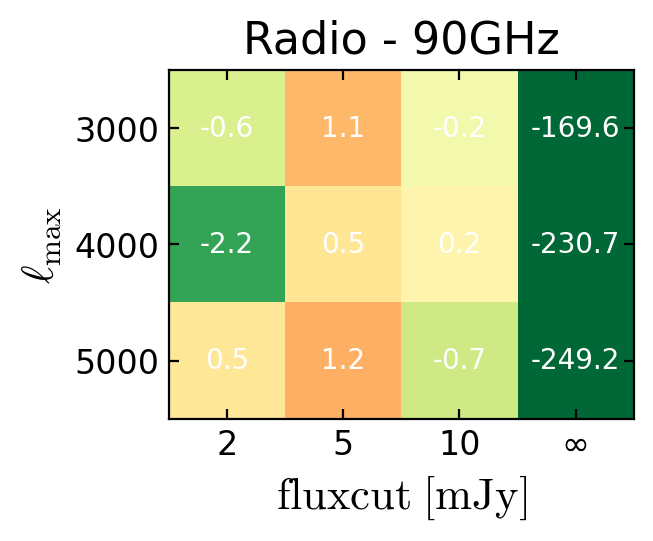

PyObject Text(0.5, 1.0, 'Radio - 90GHz')

In [26]:
figure(figsize=(3,4), dpi=200)
data = (first.(reduce(hcat, biases)))
gca().imshow(data, vmin=-3, vmax=3, cmap="RdYlGn_r")
for I in CartesianIndices(data)
    text((reverse(I.I) .- 1)..., @sprintf("%.1f",data[I]), ha="center", va="center", c="white")
end
gca().set_xticklabels([nothing,"2","5","10","∞"])
gca().set_yticklabels(2000:1000:5000);
ylabel(L"\ell_{\rm max}")
xlabel(L"{\rm fluxcut} \; [{\rm mJy}]")
title("Radio - 90GHz")

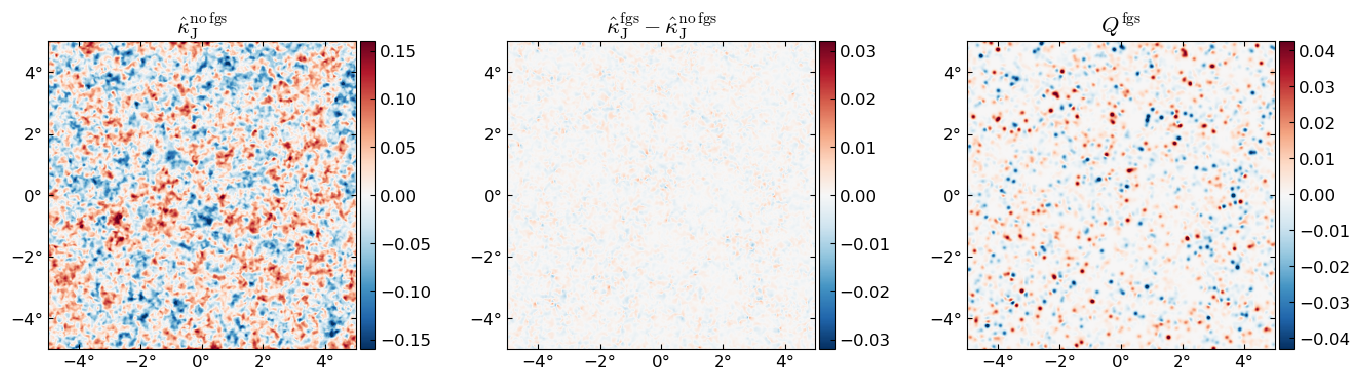

In [87]:
plot(
    permutedims([
        ∇² * MAPs[1][:nofg,:fgcov].ϕJ[!,1]/2,
        ∇² * (MAPs[1][:corrfg,:fgcov].ϕJ[!,1] - MAPs[1][:nofg,:fgcov].ϕJ[!,1])/2,
        BandPassOp(beamCℓs(beamFWHM=5)) * (Ms[source][survey,freq,fluxcut][1]*gs[source][freq][1])[:Q]
    ]),
    title = [L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}" L"Q^{\rm fgs}"],
    vlim = [0.16 0.032 :asym],
)

In [15]:
_unbatch(x) = [batch_index(x,i) for i=1:CMBLensing.batch_length(x)];

In [16]:
mean_ρℓ(k...) = mean(get_ρℓ(ϕJ,ϕs[i];ℓedges) for i in 1:8 for ϕJ in _unbatch(MAPs[i][k...].ϕJ))
mean_Cℓ(k...) = mean(get_Cℓ(ϕJ,ϕs[i];ℓedges) for i in 1:8 for ϕJ in _unbatch(MAPs[i][k...].ϕJ))
get_gs(MAP,k...) = vcat([hcat(unbatch.(g)...) for g in MAPs[:,k,:gAϕ]]...)';

In [17]:
# Cℓ_bias = Cℓ.total.ϕϕ * ((1/mean_ρℓ(:corrfg,:fgcov)^2 - 1) - (1/mean_ρℓ(:nofg,:fgcov)^2 - 1));

In [18]:
Cℓ_noise = Cℓ.total.ϕϕ * (1/mean_ρℓ(:uncorrfg,:fgcov)^2 - 1);

In [19]:
fsky = (survey==:deep ? 0.03 : 0.6)

0.03

In [28]:
MAPs[1]

Dict{Tuple{Symbol, Symbol}, NamedTuple{(:fJ, :ϕJ, :gAϕ), Tuple{LambertEBFourier{Array{ComplexF32, 4}}, LambertMap{Array{Float32, 4}}, Vector{CMBLensing.BatchedReal{Float32, Vector{Float32}}}}}} with 7 entries:
  (:gaussfg, :fgcov)  => (fJ = ComplexF32[0.0-0.0im, -4774.99-11514.4im, -8284.…
  (:corrfg, :fgcov)   => (fJ = ComplexF32[0.0-0.0im, -4735.11-11439.1im, -8258.…
  (:uncorrfg, :fgcov) => (fJ = ComplexF32[0.0-0.0im, -4727.74-11464.7im, -8230.…
  (:nofg, :nofgcov)   => (fJ = ComplexF32[0.0-0.0im, -4777.0-11451.3im, -8239.5…
  (:gaussfg2, :fgcov) => (fJ = ComplexF32[0.0-0.0im, -4775.6-11517.8im, -8309.8…
  (:corrfg, :nofgcov) => (fJ = ComplexF32[0.0-0.0im, -4735.84-11439.9im, -8270.…
  (:nofg, :fgcov)     => (fJ = ComplexF32[0.0-0.0im, -4776.71-11449.7im, -8239.…

In [20]:
get_Cℓ_bias(fg1,fg2,fg3=:gaussfg) = (Cℓ.total.ϕϕ[ℓcenters] .* (mean(get_gs(MAPs,fg1,:fgcov),dims=2) - mean(get_gs(MAPs,fg2,:fgcov),dims=2)) ./ var(get_gs(MAPs,fg3,:fgcov),dims=2))[:];

In [21]:
get_bias(Cℓ_bias) = sum(@. Cℓ_bias / σℓ^2) / sum(@. 1 / σℓ^2) * sqrt(sum(@. 1 / σℓ^2))

get_bias (generic function with 1 method)

In [22]:
Cℓ_bias = (Cℓ.total.ϕϕ[ℓcenters] .* (mean(get_gs(MAPs,:corrfg,:fgcov),dims=2) - mean(get_gs(MAPs,:gaussfg,:fgcov),dims=2)) ./ var(get_gs(MAPs,:gaussfg,:fgcov),dims=2))[:];

LoadError: ArgumentError: invalid index: (:corrfg, :fgcov) of type Tuple{Symbol, Symbol}

In [96]:
σℓ = inv(sqrt(fsky/(100/rad2deg(rad2deg(4π))))) * (Cℓ.total.ϕϕ[ℓcenters] ./ std(get_gs(MAPs,:gaussfg,:fgcov),dims=2))[:];

LoadError: ArgumentError: invalid index: (:gaussfg, :fgcov) of type Tuple{Symbol, Symbol}

In [113]:
get_bias(get_Cℓ_bias(:corrfg, :gaussfg))

-0.028333779730087473

In [114]:
get_bias(get_Cℓ_bias(:corrfg, :gaussfg2))

1.6147592748623487

In [115]:
get_bias(get_Cℓ_bias(:corrfg, :nofg))

0.14893019196172558

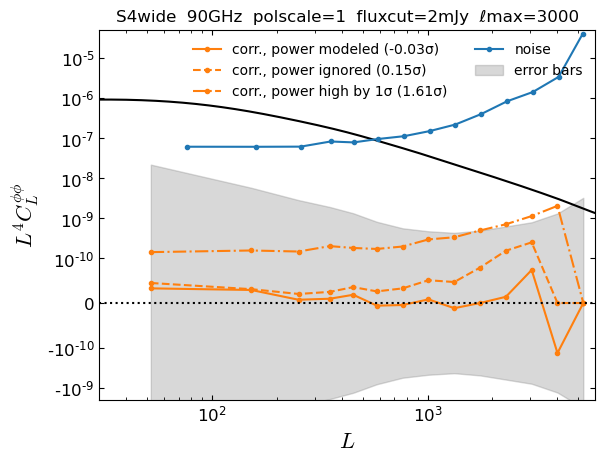

In [116]:
loglog(ℓ⁴*Cℓ.total.ϕϕ,"k")


fill_between(
    ℓcenters, 
    (x * ℓcenters.^4 .* σℓ for x=[1,-1])...,
    color="gray", alpha=0.3, ls="-", label="error bars"
)



plot(ℓcenters, ℓcenters.^4 .* get_Cℓ_bias(:corrfg,:gaussfg), "C1.-", label=@sprintf("corr., power modeled (%.02fσ)",get_bias(get_Cℓ_bias(:corrfg, :gaussfg))))
# plot(ℓcenters, ℓcenters.^4 .* get_Cℓ_bias(:uncorrfg,:gaussfg), "C2.-", label="uncorr., PS modeled")

plot(ℓcenters, ℓcenters.^4 .* get_Cℓ_bias(:corrfg,:nofg), "C1.--", label=@sprintf("corr., power ignored (%.02fσ)",get_bias(get_Cℓ_bias(:corrfg, :nofg))))
# plot(ℓcenters, ℓcenters.^4 .* get_Cℓ_bias(:uncorrfg,:nofg), "C2.--", label="uncorr., PS ignored")

plot(ℓcenters, ℓcenters.^4 .* get_Cℓ_bias(:corrfg,:gaussfg2), "C1.-.", label=@sprintf("corr., power high by 1σ (%.02fσ)",get_bias(get_Cℓ_bias(:corrfg, :gaussfg2))))
# plot(ℓcenters, ℓcenters.^4 .* get_Cℓ_bias(:uncorrfg,:gaussfg2), "C2.-.", label="uncorr., PS off by 1")

loglog(ℓ⁴*Cℓ_noise, ".-", label="noise")


axhline(0,c="k",ls=":")
title(@sprintf("S4%s  %iGHz  polscale=%i  fluxcut=%imJy  ℓmax=%i", survey, freq, polfrac_scale, fluxcut, ℓmax_data), fontsize=12)

legend(ncol=2, fontsize=10, loc="upper right")
xlim(30,6000)
yscale("symlog", linthreshy=1e-10)
ylim(-2e-9,5e-5)

xlabel(L"L")
ylabel(L"L^4 C_L^{\phi\phi}")

for ext in ["pdf","png"]
    savefig(joinpath("figures", savename((;survey,freq,ℓmax_data,fluxcut,polfrac_scale), ext)), bbox_inches="tight")
end

# Maps

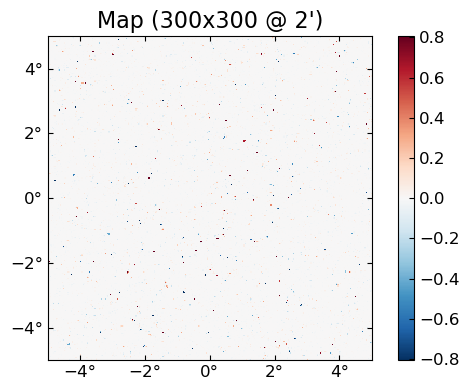

In [140]:
plot(gs_radio[150][1][:Q])

In [ ]:
plot(
    permutedims([
        diag(Ms_radio[150][2][1])[:Q],
        ∇² * batchindex(MAPs[1][:nofg,:fgcov].ϕ,1)/2,
        ∇² * (batchindex(MAPs[1][:corrfg,:fgcov].ϕ,1) - batchindex(MAPs[1][:nofg,:fgcov].ϕ,1))/2
    ]),
    title = [L"{\rm mask} \; (S_{\rm cut}^{150}=2\,{\rm mJy})" L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}"],
    vlim = [(0,1) 0.16 0.016],
    cmap = ["Greys" "RdBu_r" "RdBu_r"]
)

In [ ]:
plot(, which=[:Qx])

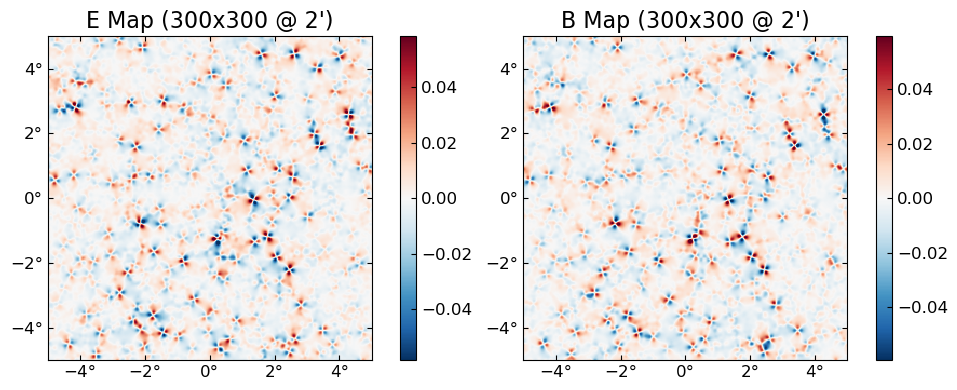

In [195]:
plot(BandPassOp(beamCℓs(beamFWHM=5)) * (Ms_radio[150][10][1]*gs_radio[150][1]))

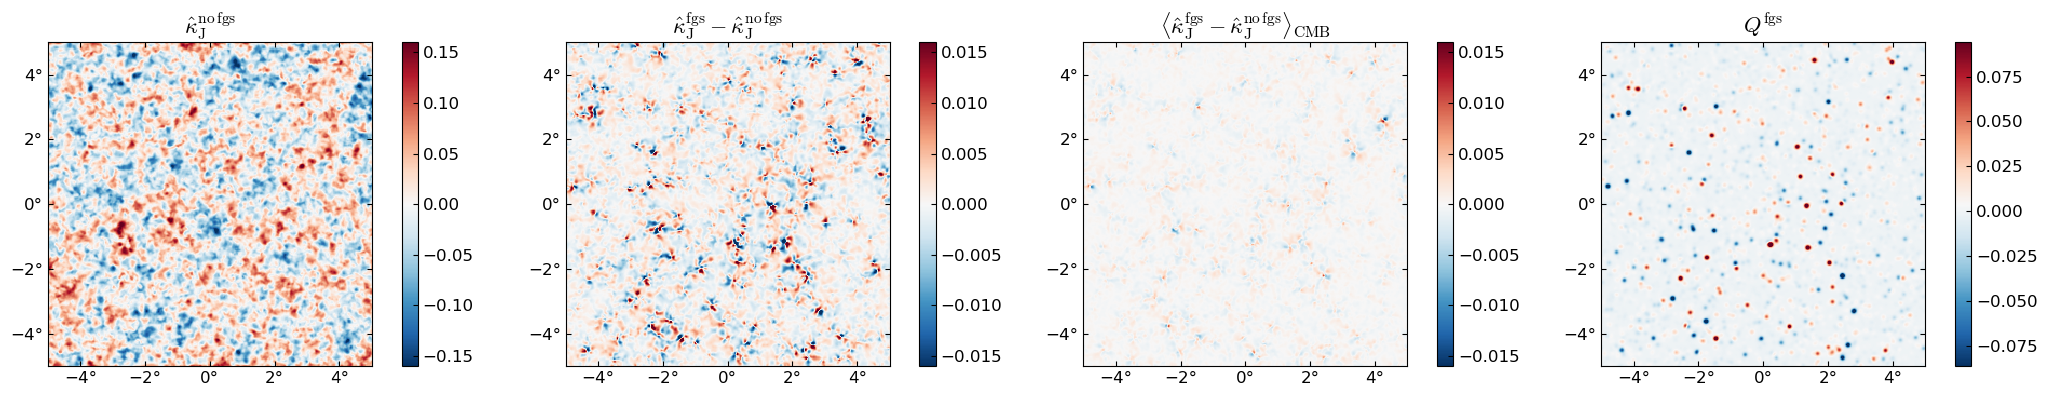

In [191]:
plot(
    permutedims([
        ∇² * batchindex(MAPs[1][:nofg,:fgcov].ϕ,1)/2,
        ∇² * unbatch(MAPs[1][:corrfg,:fgcov].ϕ - MAPs[1][:nofg,:fgcov].ϕ)[1]/2,
        ∇² * mean(unbatch(MAPs[1][:corrfg,:fgcov].ϕ - MAPs[1][:nofg,:fgcov].ϕ))/2,
        BandPassOp(beamCℓs(beamFWHM=5)) * (Ms_radio[150][10][1]*gs_radio[150][1])[:Q]
    ]),
    title = [L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}" L"\langle \hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs} \rangle_{\rm CMB}" L"Q^{\rm fgs}"],
    vlim = [0.16 0.016 0.016 :asym],
)

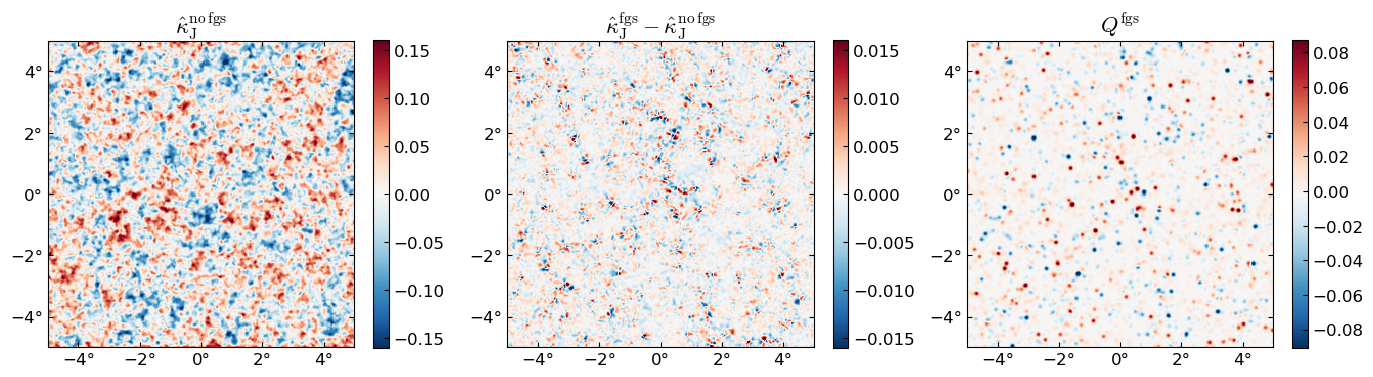

In [13]:
plot(
    permutedims([
        ∇² * batchindex(MAPs[1][:nofg,:fgcov].ϕJ,1)/2,
        ∇² * (batchindex(MAPs[1][:corrfg,:fgcov].ϕJ,1) - batchindex(MAPs[1][:nofg,:fgcov].ϕJ,1))/2,
        BandPassOp(beamCℓs(beamFWHM=5)) * (Ms_radio[survey,freq,fluxcut][1]*gs_radio[freq][1])[:Q]
    ]),
    title = [L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}" L"Q^{\rm fgs}"],
    vlim = [0.16 0.016 :asym],
)

In [ ]:
@time map(collect(noises)) do (noise_key, noise_kwargs)
    map([3000,5000]) do ℓmax_data
        map([2,10]) do fluxcut
            map([1,2]) do polfrac_scale

                filename = "MAPs/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale).jld2"
                
                if isfile(filename)
                
                    MAPs = load(filename, "MAPs");

                    Cℓ_bias  = Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:corrfg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1))
                    Cℓ_noise = Cℓ.total.ϕϕ *  (1/mean(get_ρℓ(MAPs[i][:corrfg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1);
                    fsky = (noise_key==:deep ? 1500 : 20000) / 42000
                    σℓ = (Cℓ.total.ϕϕ + Cℓ_noise) * CMBLensing.FuncCℓs(ℓ -> √(2/((2ℓ+1)*fsky)));

                    Tℓ = mean(get_Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims) / mean(get_Cℓ(ϕs[i], ℓedges=ℓedges) for i=sims)

                    
                    map([100:2000, 100:3000]) do ℓrange_Aϕ

                        b̂ = sum((Cℓ_bias / σℓ^2)[ℓrange_Aϕ]) / sum((1 / σℓ^2)[ℓrange_Aϕ])
                        σb̂ = 1 / sqrt(sum((1 / σℓ^2)[ℓrange_Aϕ]))
                        b̂ / σb̂

                        fgcov=:fgcov

                        figure()

                        loglog(ℓ⁴ * Cℓ.total.ϕϕ,"k")
                        for i=sims
                            loglog(ℓ⁴ * Cℓ.total.ϕϕ *  (1/get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1), "C0", alpha=0.1)
#                             loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1) - (1/get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1)),"C1",alpha=0.1)
#                             loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/get_ρℓ(MAPs[i][:uncorrfg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1) - (1/get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1)),"C2",alpha=0.1)    
                        end
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ( 1/mean(get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1), 
                            "C0", label="noise")
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1)),
                            "C1", label="foreground bias (spatially correlated)")
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:uncorrfg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1)),
                            "C2", label="foreground bias (spatially uncorrelated)")
                        loglog(ℓ⁴ * σℓ, c="gray",ls="--", label="σ(Cℓ) S4$(noise_key)")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:corrfg,  :fgcov].ϕ, ℓedges=ℓedges) - get_ℓ⁴Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C1--")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:uncorrfg,:fgcov].ϕ, ℓedges=ℓedges) - get_ℓ⁴Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C2--")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:corrfg,  :fgcov].ϕ - MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C1:")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:uncorrfg,:fgcov].ϕ - MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C2:")

                        axvspan(first(ℓrange_Aϕ), last(ℓrange_Aϕ), color="gray", alpha=0.2)

                        legend(loc="lower left",frameon=true)
                        yscale("symlog",linthreshy=1e-10)
                        ylim(-1e-8, 2e-6)
                        xlim(30,6000)
                        title(@sprintf("S4%s  polscale=%i  fluxcut=%imJy  bias=%.2fσ", noise_key, polfrac_scale, fluxcut, b̂ / σb̂), fontsize=14)
                        savefig(
                            "plots/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale)_Aphi_$(first(ℓrange_Aϕ))_$(last(ℓrange_Aϕ)).pdf", 
                            bbox_inches="tight"
                        )
                        close()
                        
                    end
                    
                end
            end
        end
    end
end